# The evidential alternative to *p* values 

In [1]:
loadpackages = function(){
  suppressMessages(require(tidyverse))
  suppressMessages(require(brms))
  suppressMessages(require(bayesplay))
  suppressMessages(require(BayesFactor))
  suppressMessages(require(logspline))
  suppressMessages(require(furrr))
  suppressMessages(require(magrittr))
  suppressMessages(require(patchwork))
  suppressMessages(require(IRdisplay))
  suppressMessages(require(glue))

}

loadpackages()

In [2]:
#1 

# set up the functions that plot the distributions of results for 
# various values of pr_heads

# function v1 "simulates" results from the version where you
# flip the coin n times and then count up the heads. 
# three parameters need to be set
# 1. the number of flips (n_flips)
# 2. the probability of heads (pr_heads)
# 3. the number of heads in our observation (obs_heads)

coin_flip_v1 = function(n_flips, pr_heads, obs_heads){

  pmap_df(tibble(heads = 1:n_flips, flips = n_flips, pr_heads = pr_heads), # input values
    
 function(heads, flips, pr_heads)
     tibble(flips = flips, heads = heads, 
  freq = dbinom(heads, flips, pr_heads))) %>% # get the frequency 
  mutate(our_ob = case_when(flips == n_flips & heads == obs_heads ~ TRUE, TRUE ~ FALSE)) # mark our observation
    
}
            
# function v2 "simulates" results from the version where you 
# flip the coin until it comes up tails n times.
# three parameters need to be set
# 1. the number of tails to stop at (n_tails)
# 2. the probability of heads (pr_heads)
# 3. the number of flips in our observation (obs_flips)
          
coin_flip_v2 = function(n_tails,pr_heads,obs_flips){
    pmap_df(tibble(tails = n_tails, pr_heads = pr_heads, flips = 1:(obs_flips+4)), # input values
            
        function(tails, pr_heads, flips) tibble(flips = flips, tails = tails, 
        freq = dnbinom(flips - tails, tails, 1 - pr_heads))) %>% 
  mutate(our_ob = case_when(flips == obs_flips  & tails == tails ~ TRUE, TRUE ~ FALSE)) # mark our observation
}

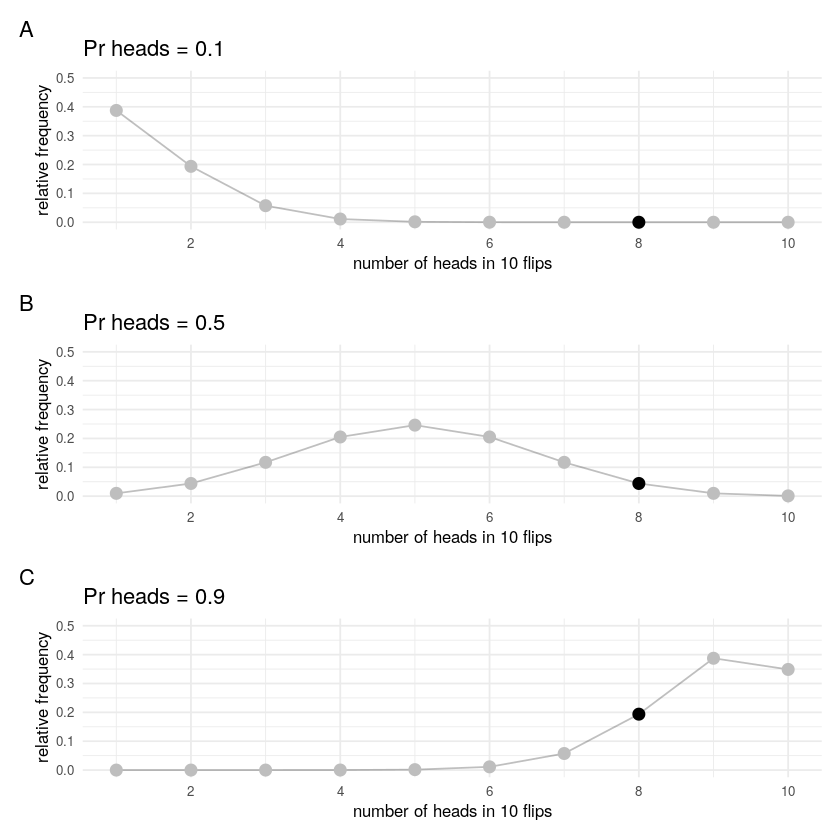

In [3]:
# 2
# draw distributions of the data for various values of pr_heads for version 1 (flip n times)

n_flips = 10
pr_heads_values = c(1/10,5/10,9/10) # set our pr_heads values
obs_heads = 8

# make the plots
coin_flip_v1_plots = pmap(tibble(n_flips = n_flips, pr_heads = pr_heads_values, obs_heads = obs_heads),
                          function(n_flips, pr_heads, obs_heads) 
                            coin_flip_v1(n_flips, pr_heads, obs_heads) %>%
                            ggplot(aes(x = heads, y = freq)) + geom_line(alpha = .25) +
                            geom_point(aes(colour = our_ob), size = 3)  +
                            scale_colour_manual(guide = "none", values = c("TRUE" = "black", "FALSE" = "grey")) + 
                            labs(x = glue("number of heads in {n_flips} flips"),
                                 y = "relative frequency", 
                                title = glue("Pr heads = {pr_heads}")) + theme_minimal())

# make the plots pretty and arrange them
coin_flip_v1_plots = map(coin_flip_v1_plots, 
    function(x) x + scale_x_continuous(breaks = seq(0,10,2)) + 
                    scale_y_continuous(limits = c(0,.5)) +
                         theme(axis.text = element_text(size = 8), 
                               axis.title = element_text(size = 10)))

patchwork::wrap_plots(coin_flip_v1_plots,nrow = 3) + plot_annotation(tag_levels = "A")

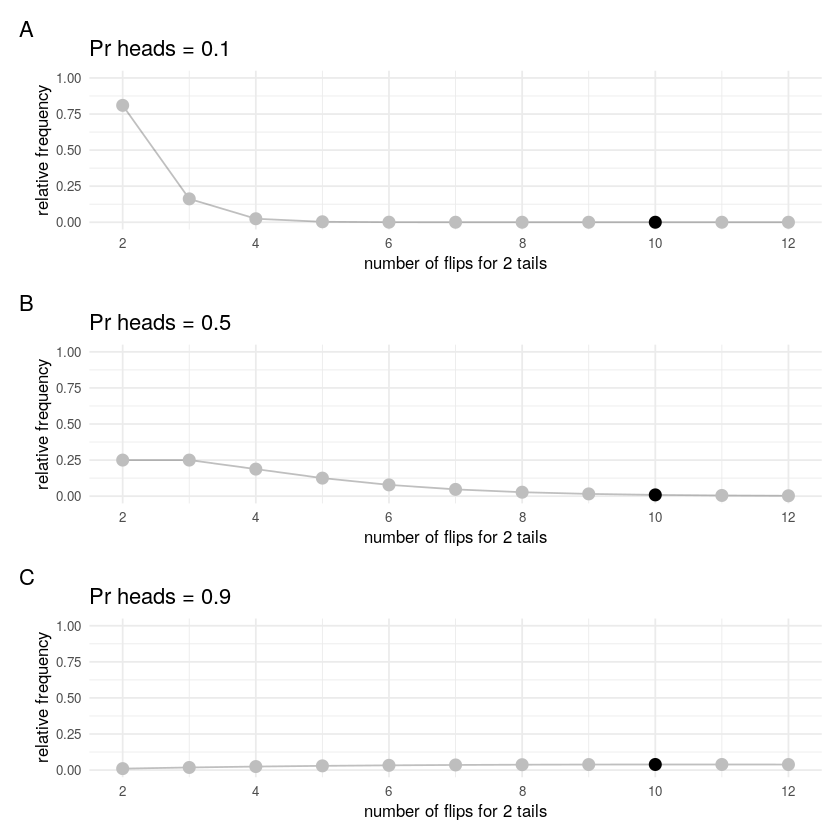

In [4]:
# 3
# draw distributions of the data for various values of pr_heads for version 2 (flip until n tails)

n_tails = 2
pr_heads_values = c(1/10,5/10,9/10) # set our pr_heads values
obs_flips = 10

# make the plots
coin_flip_v2_plots = pmap(tibble(n_tails = n_tails, pr_heads = pr_heads_values, obs_flips = obs_flips),
                          function(n_tails,pr_heads,obs_flips) 
                            coin_flip_v2(n_tails,pr_heads,obs_flips) %>%
                            ggplot(aes(x = flips, y = freq)) + geom_line(alpha = .25, na.rm = TRUE) +
                            geom_point(aes(colour = our_ob), size = 3, na.rm = TRUE) + 
                            scale_colour_manual(guide = "none", values = c("TRUE" = "black", "FALSE" = "grey")) + 
                            labs(x = glue("number of flips for {n_tails} tails"),
                                 y = "relative frequency", 
                                title = glue("Pr heads = {pr_heads}")) + theme_minimal())

# make the plots pretty and arrange them
coin_flip_v2_plots = map(coin_flip_v2_plots, 
    function(x) x + scale_x_continuous(breaks = seq(2,12,2), limits = c(2,12)) + 
                    scale_y_continuous(limits = c(0,1)) +
                         theme(axis.text = element_text(size = 8), 
                               axis.title = element_text(size = 10)))

patchwork::wrap_plots(coin_flip_v2_plots,nrow = 3) + plot_annotation(tag_levels = "A")

In [5]:
# 4
# first set our observation again
number_of_heads = 8
number_of_flips = 10

# and set the range of bias to consider
pr_heads_range = seq(0,1,.1) # 0/10, 1/10 ... 9/10, 10/10

# translate our observation into the parameters needed for version 1
# generate the data and pull out the relative frequency of our specific observation

n_flips = number_of_flips
obs_heads = number_of_heads
likelihood_v1 = map_df(pr_heads_range, function(x) coin_flip_v1(n_flips, x, obs_heads) %>% 
 filter(our_ob == TRUE) %>% select(freq) %>% mutate(pr_heads = x))


# translate our observation into the parameters needed for version 2
# generate the data and out the relative frequency of our specific observation
n_tails = number_of_flips - number_of_heads
obs_flips = number_of_flips
likelihood_v2 = map_df(pr_heads_range, function(x) 
    suppressWarnings( # supress warnings about impossible values 
        coin_flip_v2(n_tails,x,obs_flips) %>%
    filter(our_ob == TRUE) %>% select(freq) %>% mutate(pr_heads = x) %>%
    mutate(freq = ifelse(is.na(freq), 0, freq)))) # replace NaN (impossible values) with 0 for plotting



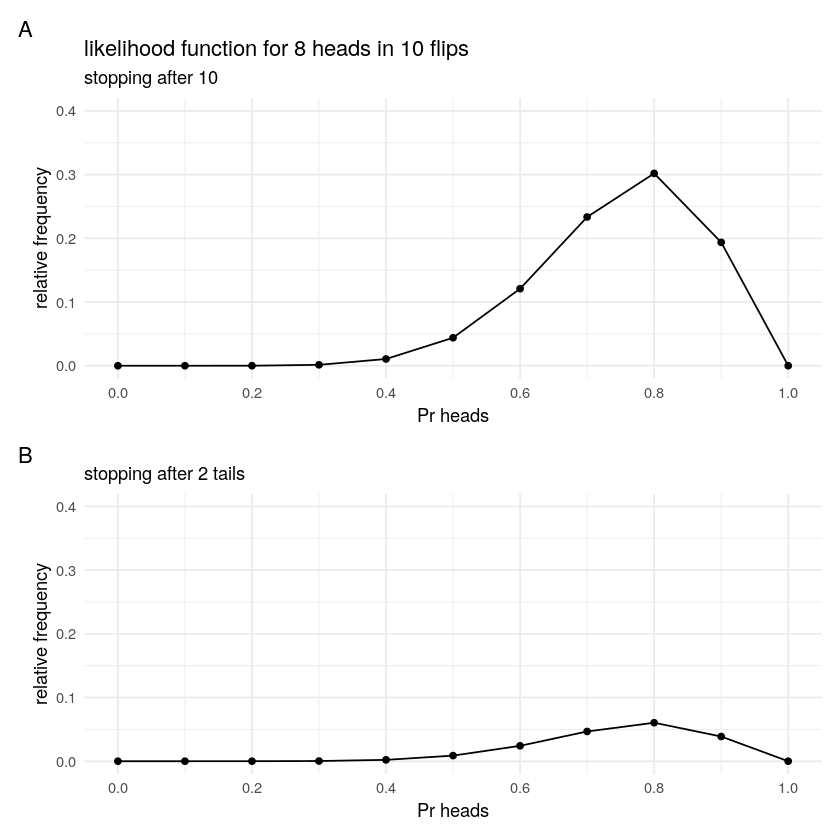

In [6]:
# 5
# now actually draw the plots

likelihood_v1_plot = likelihood_v1 %>% ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal() + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,.4), name = "relative frequency") +
labs(title = glue("likelihood function for {number_of_heads} heads in {number_of_flips} flips"),
    subtitle = glue("stopping after {number_of_flips}"))

likelihood_v2_plot = likelihood_v2 %>% ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal() + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,.4), name = "relative frequency") + 
labs(tile = glue("likelihood function for {number_of_heads} in {number_of_flips}"), 
   subtitle = glue("stopping after {n_tails} tails"))


likelihood_v1_plot / likelihood_v2_plot + plot_annotation(tag_levels = "A")

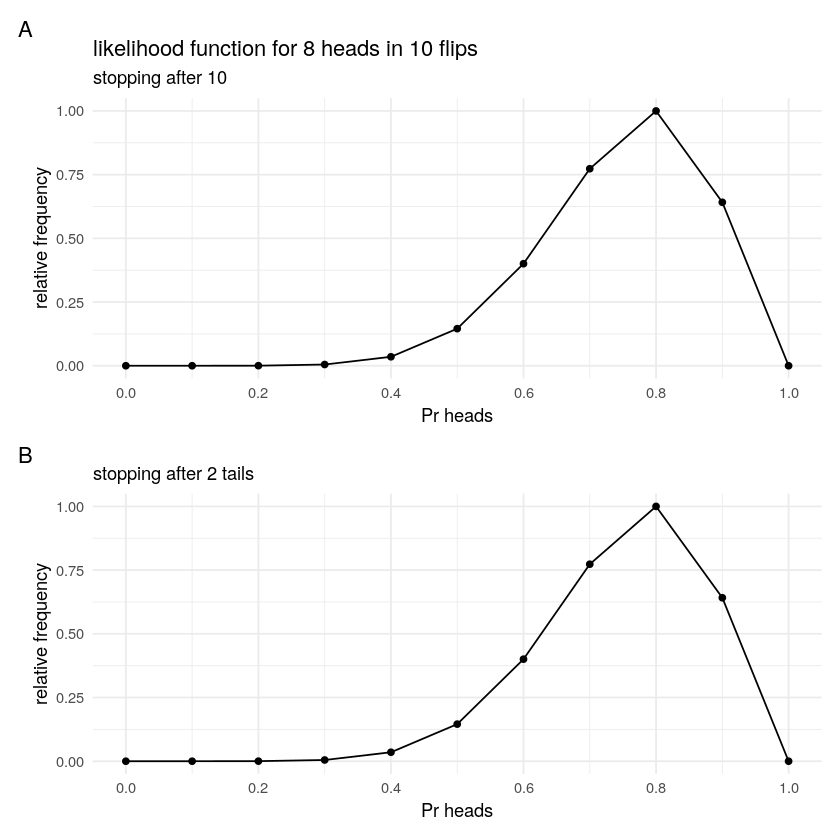

In [7]:
# 6
# now actually draw the scaled plots

likelihood_v1_plot = likelihood_v1  %>% mutate(freq = freq / max(freq)) %>%
ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal() + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,1), name = "relative frequency") +
labs(title = glue("likelihood function for {number_of_heads} heads in {number_of_flips} flips"),
    subtitle = glue("stopping after {number_of_flips}"))

likelihood_v2_plot = likelihood_v2 %>% mutate(freq = freq / max(freq)) %>%
ggplot(aes(x = pr_heads, y = freq)) + geom_point() + geom_line() + 
theme_minimal() + scale_x_continuous(name = "Pr heads", breaks = seq(0,1,.2)) + 
scale_y_continuous(limits = c(0,1), name = "relative frequency") + 
labs(tile = glue("likelihood function for {number_of_heads} in {number_of_flips}"), 
   subtitle = glue("stopping after {n_tails} tails"))


likelihood_v1_plot / likelihood_v2_plot + plot_annotation(tag_levels = "A")

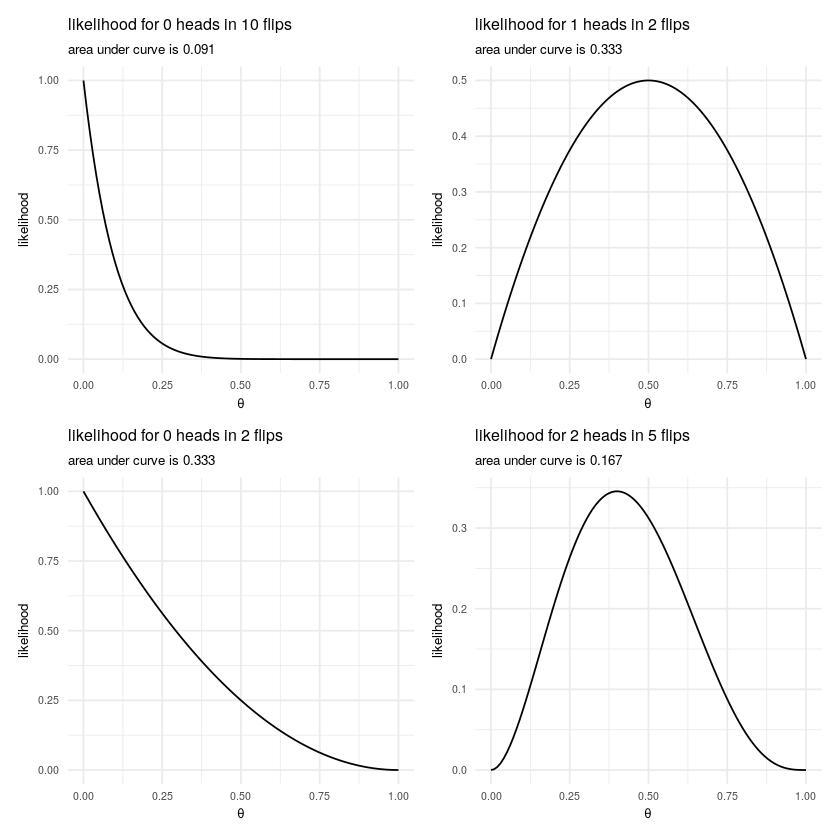

In [8]:
#7

# plot some likelihood functions 

list(p1 = c(heads = 0, flips = 10),p2 = c(heads = 1, flips = 2),p3 = c(heads = 0, flips = 2),p4 = c(heads = 2, flips = 5)) -> scenarios
map(scenarios, function(x) {dbinom.like <- function(t) dbinom(x[["heads"]],x[["flips"]],t); integrate(dbinom.like,0,1)$value %>% tibble(heads = x[["heads"]], flips = x[["flips"]], auc = .)}) -> aucs
map(aucs, function(x) ggplot(mapping = aes(x = seq(0,1,length.out = 100), y = dbinom(x$heads,x$flips,seq(0,1,length.out = 100)))) + geom_line() + labs(y = "likelihood", x = "θ", title = glue::glue("likelihood for {x$heads} heads in {x$flips} flips"), subtitle = glue::glue("area under curve is {round(x$auc,3)}")) + theme_minimal() + theme(text = element_text(size = 8))) -> plots
(plots$p1 + plots$p2) / (plots$p3 + plots$p4) 

In [9]:
# 8 

# set out observation
n = 10 # number of flips
h = 8 # number of heads
t = n - h # number of tails

# set our two observation
h1 = 0.6 # the probability of getting heads is 0.6
h2 = 0.8 # the probability of getting heads is 0.8

L1 = dbinom(h,n, h1) 
L2 = dbinom(h,n, h2) 
glue::glue("The likelihood under $\\mathcal{{H}}_1$ ($Pr_{{heads}}$ = {h1}) is {round(L1,2)}  
The likelihood under $\\mathcal{{H}}_2$ ($Pr_{{heads}}$ = {h2}) is {round(L2,2)}   
The likelihood ratio is {round(L1/L2,2)}  
The data are {round(L1/L2,2)} times more probable under $\\mathcal{{H}}_1$ than $\\mathcal{{H}}_2$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{H}_1$ ($Pr_{heads}$ = 0.6) is 0.12  
The likelihood under $\mathcal{H}_2$ ($Pr_{heads}$ = 0.8) is 0.3   
The likelihood ratio is 0.4  
The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

In [10]:
# 9 

# Set our observation
n = 10 # number of flips
h = 8 # number of heads
t = n - h # number of tails

# set our two hypotheses
h1 = 0.6 # the probability of getting heads is 0.6
h2 = 0.8 # the probability of getting heads is 0.8

L1 = dnbinom(t,h,h1)
L2 = dnbinom(t,h,h2)
glue::glue("The likelihood under $\\mathcal{{H}}_1$ ($Pr_{{heads}}$ = {h1}) is {round(L1,2)}  
The likelihood under $\\mathcal{{H}}_2$ ($Pr_{{heads}}$ = {h2}) is {round(L2,2)}   
The likelihood ratio is {round(L1/L2,2)}  
The data are {round(L1/L2,2)} times more probable under $\\mathcal{{H}}_1$ than $\\mathcal{{H}}_2$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{H}_1$ ($Pr_{heads}$ = 0.6) is 0.1  
The likelihood under $\mathcal{H}_2$ ($Pr_{heads}$ = 0.8) is 0.24   
The likelihood ratio is 0.4  
The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

In [16]:
# 10
# Set our observation
n = 10 # number of flips
h = 8 # number of heads


# set our two hypotheses
h1 = 0.5 # the probability of getting heads is 0.5
h2 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10

M0 = dbinom(h,n, h1)
M1 = dbinom(h,n, h2); M1 = mean(M1)


glue::glue("The likelihood under $\\mathcal{{M}}_0$ is {round(M0,2)}  
The likelihood under $\\mathcal{{M}}_1$ is {round(M1,2)}   
The likelihood ratio is {round(M0/M1,2)}  
The data are {round(M0/M1,2)} times more probable under $\\mathcal{{M}}_0$ than $\\mathcal{{M}}_1$   
The data are {round(M1/M0,2)} times more probable under $\\mathcal{{M}}_1$ than $\\mathcal{{M}}_0$") %>% 
IRdisplay::display_markdown()


The likelihood under $\mathcal{M}_0$ is 0.04  
The likelihood under $\mathcal{M}_1$ is 0.08   
The likelihood ratio is 0.53  
The data are 0.53 times more probable under $\mathcal{M}_0$ than $\mathcal{M}_1$   
The data are 1.87 times more probable under $\mathcal{M}_1$ than $\mathcal{M}_0$

In [17]:
# 11

# Set our observation
n = 10 # number of flips
h = 8 # number of heads


# set our two hypotheses
h1 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10
h2 = seq(0,1,.1) # the probability of getting heads is all possible values from 0/10 to 10/10 in steps of 1/10

# set out weightings
w1 = c(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0) # set the weights
w1 = w1 / sum(w1) # make sure weights sum to 1

w2 = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1) # set the weights
w2 = w2 / sum(w2) # make sure weights sum to 1
         

M = dbinom(h,n, h1) # generate the likelihood

M0 = mean(M * w1) # take a weighted average of the likelihood
M1 = mean(M * w2) # take a weighted average of the likelihood



glue::glue("The likelihood under $\\mathcal{{M}}_0$ is {round(M0,3)}  
The likelihood under $\\mathcal{{M}}_1$ is {round(M1,3)}   
The likelihood ratio is {round(M0/M1,2)}  
The data are {round(M0/M1,2)} times more probable under $\\mathcal{{M}}_0$ than $\\mathcal{{M}}_1$   
The data are {round(M1/M0,2)} times more probable under $\\mathcal{{M}}_1$ than $\\mathcal{{M}}_0$") %>% 
IRdisplay::display_markdown()

The likelihood under $\mathcal{M}_0$ is 0.004  
The likelihood under $\mathcal{M}_1$ is 0.007   
The likelihood ratio is 0.53  
The data are 0.53 times more probable under $\mathcal{M}_0$ than $\mathcal{M}_1$   
The data are 1.87 times more probable under $\mathcal{M}_1$ than $\mathcal{M}_0$